In [1]:
# imports
from scipy.optimize import differential_evolution, minimize
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 

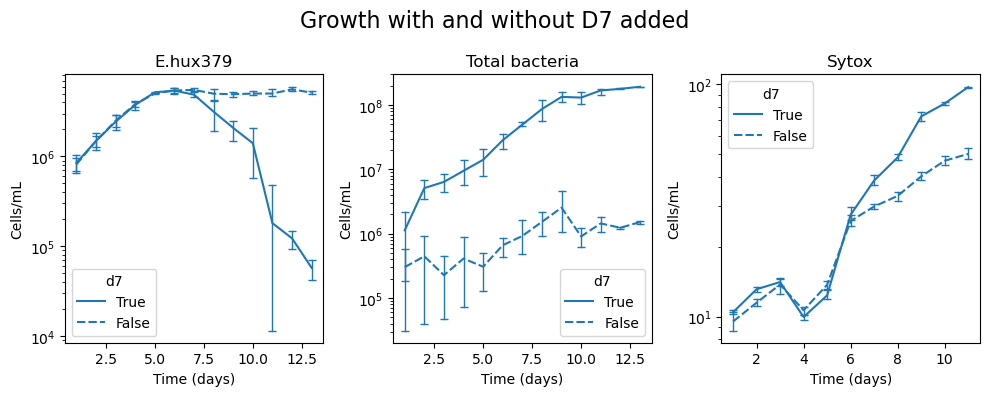

In [2]:
# data
# load data func
def load_data(path="ehux_exp.xlsx"):
    df = pd.read_excel(path)
    df = df.melt(
        id_vars=['time', 'name', 'treatment_conc', 'treatment', 'd7', 'host'], 
        value_vars=['r1', 'r2', 'r3'],
        var_name='replicate',
        value_name='r'
    )
    df['cell_dmsp'] = df['r'] * 0.8
    df = df[df['time'] != 0].reset_index(drop=True)
    return df

# plot data func
def plot_line(ax, df, x='time', y='r', hue='treatment_conc', style='d7',
              title=None, ylabel='Cells/mL', xlabel='Time (days)', logscale=True, palette='tab10', **kwargs):
    sns.lineplot(
        data=df, x=x, y=y, hue=hue, style=style, style_order=[True, False], ax=ax,
        errorbar='pi', err_style='bars', palette=palette,
        err_kws={'capsize': 3, 'elinewidth': 1},
        **kwargs
    )
    if logscale:
        ax.set_yscale('log')
    if title:
        ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    # ax.legend(
    #           loc="upper center",      # place legend in the center
    #           bbox_to_anchor=(0.5, -0.2),  # push below axis label
    #           ncol=2,                  # make labels go side by side
    #           frameon=True            # optional: remove box
    # )
    return ax

# filter data func
def filter_df(df, **filters):
    if not filters:
        return df
    mask = pd.Series(True, index=df.index)
    for col, val in filters.items():
        mask &= df[col] == val
    return df.loc[mask]

# load and filter data
df=filter_df(df=load_data(), treatment='none', treatment_conc='none', host='ehux379')

# plot
f, ax = plt.subplots(1,3, figsize=(10,4))
plot_line(ax=ax[0], df=filter_df(df, name='ehux379'), hue=None, palette=None)
plot_line(ax=ax[1], df=filter_df(df, name='bacteria'), hue=None, palette=None)
plot_line(ax=ax[2], df=filter_df(df, name='sytox'), hue=None, palette=None)
f.suptitle('Growth with and without D7 added', fontsize=16)
ax[0].set_title('E.hux379')
ax[1].set_title('Total bacteria')
ax[2].set_title('Sytox')
plt.tight_layout()

In [6]:
df=filter_df(df=load_data(), treatment='none', treatment_conc='none', host='ehux379')

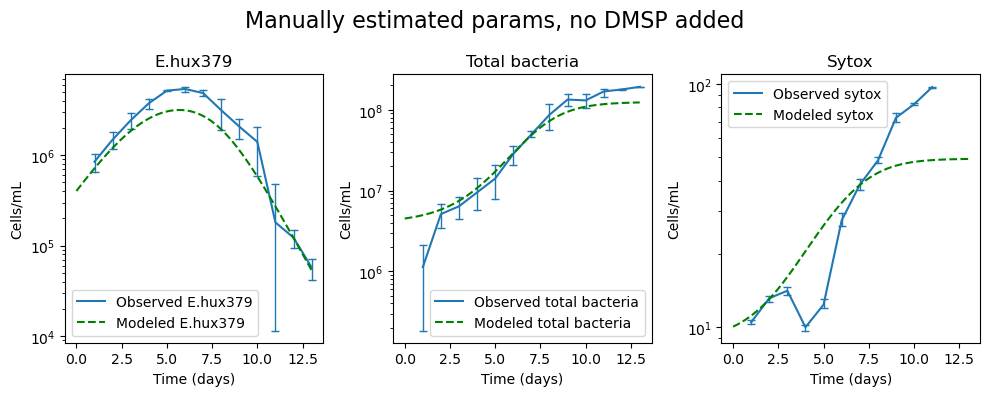

In [3]:
# model

DEFAULT_PARAMS = {
    'H0': 4.0e5, 'B0': 5e5, 'P0': 4e6, 'k': 5.5e6, 'D0': 10,
    'H_mu': 0.7, 'B_mu': 0.1, 'D_mu': 2e-6, 'beta': 14, 'phi': 1.25e-8
}

def simulate_growth(params=None, order=None, tmin=0, tmax=20, dt=0.01):
    """
    Compact simulator.
    - params: dict of parameter_name->value OR sequence of values (then provide `order`).
    - order: list of parameter names for the sequence case (e.g. ['H_mu','phi'])
    - returns: times, Hs, Bs, Ps, Ds, BPs (numpy arrays)
    """
    p = DEFAULT_PARAMS.copy()
    if params is not None:
        if isinstance(params, dict):
            p.update(params)
        else:
            if order is None:
                raise ValueError("If params is a sequence, provide `order` list of names.")
            if len(params) != len(order):
                raise ValueError("Length of params sequence and order must match.")
            for name, val in zip(order, params):
                p[name] = val

    times = np.arange(tmin, tmax, dt)
    H, B, P, D = p['H0'], p['B0'], p['P0'], p['D0']
    Hs, Bs, Ps, Ds, BPs = [], [], [], [], []

    for _ in times:
        H += dt * (p['H_mu'] * H * (1 - (H / p['k'])) - p['phi'] * H * P)
        B += dt * (p['B_mu'] * B)
        P += dt * (p['beta'] * p['phi'] * H * P)
        D += dt * (p['D_mu'] * H)
        Hs.append(H); Bs.append(B); Ps.append(P); Ds.append(D); BPs.append(B + P)

    return times, np.array(Hs), np.array(Bs), np.array(Ps), np.array(Ds), np.array(BPs)

times, Hs, Bs, Ps, Ds, BPs = simulate_growth(tmax=13, dt=0.01)

f, ax = plt.subplots(1,3, figsize=(10,4))
plot_line(ax=ax[0], df=filter_df(df, name='ehux379', d7=True), style=None, hue=None, palette=None, label="Observed E.hux379")
plot_line(ax=ax[1], df=filter_df(df, name='bacteria', d7=True), style=None, hue=None, palette=None, label="Observed total bacteria")
plot_line(ax=ax[2], df=filter_df(df, name='sytox', d7=True), style=None, hue=None, palette=None, label="Observed sytox")
sns.lineplot(x=times, y=Hs, ax=ax[0], label='Modeled E.hux379', linestyle='--', c='green')
sns.lineplot(x=times, y=BPs, ax=ax[1], label='Modeled total bacteria', linestyle='--', c='green')
sns.lineplot(x=times, y=Ds, ax=ax[2], label='Modeled sytox', linestyle='--', c='green')
f.suptitle('Manually estimated params, no DMSP added', fontsize=16)
ax[0].set_title('E.hux379')
ax[1].set_title('Total bacteria')
ax[2].set_title('Sytox')
plt.tight_layout()

In [4]:
# Parameters to fit
param_names = ['phi', 'beta']
bounds = [(1e-9, 1e-7),    # phi bounds
          (1, 100)]        # beta bounds
# Example observed data (replace with real data)
t_obs = filter_df(df, name='ehux379', d7=True)['time']
H_obs = filter_df(df, name='ehux379', d7=True)['r']
BP_obs = filter_df(df, name='bacteria', d7=True)['r']
D_obs = filter_df(df, name='sytox', d7=True)['r']

def mse_norm(y_true, y_pred):
    scale = np.max(y_true) - np.min(y_true)
    if scale == 0: scale = np.mean(y_true)
    return np.mean((y_true - y_pred)**2) / (scale**2)

def cost_function(params):
    # simulate with current guess
    times, Hs, Bs, Ps, Ds, BPs = simulate_growth(params, order=param_names,
                                                 tmin=0, tmax=20, dt=0.01)
    # interpolate model onto observed timepoints
    H_model = np.interp(t_obs, times, Hs)
    BP_model = np.interp(t_obs, times, BPs)
    D_model = np.interp(t_obs, times, Ds)
    error = (mse_norm(H_obs, H_model) +
         mse_norm(BP_obs, BP_model))
    return error

result = differential_evolution(cost_function, bounds)
print("Best parameters:", dict(zip(param_names, result.x)))
print("Error:", result.fun)


Best parameters: {'phi': np.float64(7.180936836523865e-09), 'beta': np.float64(20.71510286648951)}
Error: 0.031961781441093455


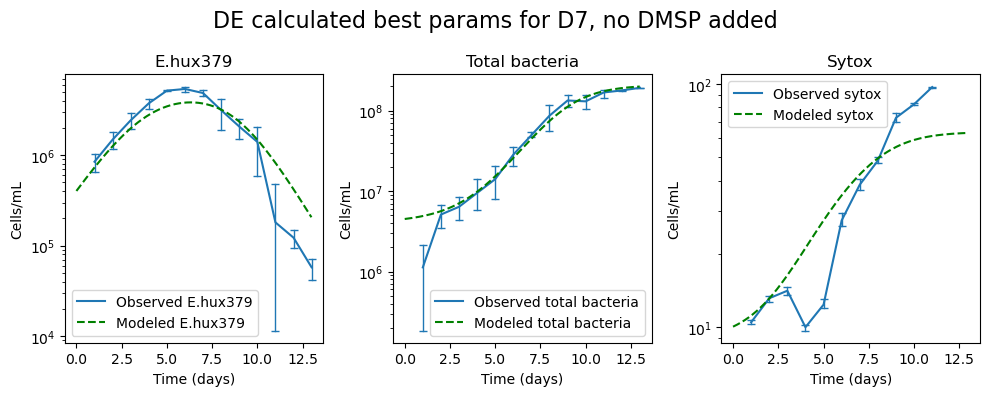

In [5]:
# plot DE estimated best fit
# enter estimated best params
times, Hs, Bs, Ps, Ds, BPs = simulate_growth(tmax=13, dt=0.01, params={
    'beta': 20.820848468670768, 'phi': 7.108034726164281e-09
})

f, ax = plt.subplots(1,3, figsize=(10,4))
plot_line(ax=ax[0], df=filter_df(df, name='ehux379', d7=True), style=None, hue=None, palette=None, label="Observed E.hux379")
plot_line(ax=ax[1], df=filter_df(df, name='bacteria', d7=True), style=None, hue=None, palette=None, label="Observed total bacteria")
plot_line(ax=ax[2], df=filter_df(df, name='sytox', d7=True), style=None, hue=None, palette=None, label="Observed sytox")
sns.lineplot(x=times, y=Hs, ax=ax[0], label='Modeled E.hux379', linestyle='--', c='green')
sns.lineplot(x=times, y=BPs, ax=ax[1], label='Modeled total bacteria', linestyle='--', c='green')
sns.lineplot(x=times, y=Ds, ax=ax[2], label='Modeled sytox', linestyle='--', c='green')
f.suptitle('DE calculated best params for D7, no DMSP added', fontsize=16)
ax[0].set_title('E.hux379')
ax[1].set_title('Total bacteria')
ax[2].set_title('Sytox')
plt.tight_layout()

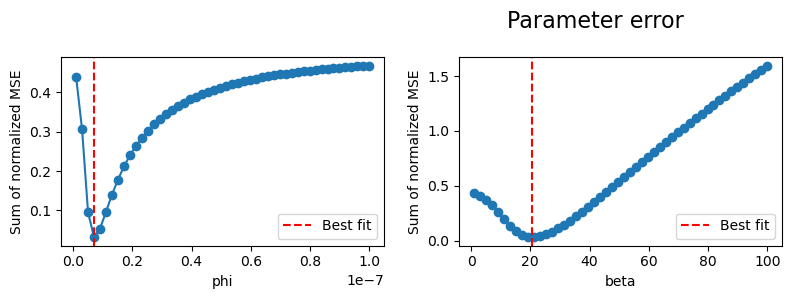

In [6]:
best_params = result.x

def scan_param(idx, n_points=50):
    """Scan one parameter index, keeping others fixed at best fit."""
    param_values = np.linspace(bounds[idx][0], bounds[idx][1], n_points)
    errors = []
    for val in param_values:
        test_params = best_params.copy()
        test_params[idx] = val
        errors.append(cost_function(test_params))
    return param_values, np.array(errors)

plt.figure(figsize=(12,3))
for i, name in enumerate(param_names):
    vals, errs = scan_param(i)
    plt.subplot(1,3,i+1)
    plt.plot(vals, errs, '-o')
    plt.axvline(best_params[i], color='r', linestyle='--', label="Best fit")
    plt.xlabel(name); plt.ylabel("Sum of normalized MSE")
    plt.legend()
plt.suptitle('Parameter error', fontsize=16)
plt.tight_layout()
plt.show()

# linear phi function

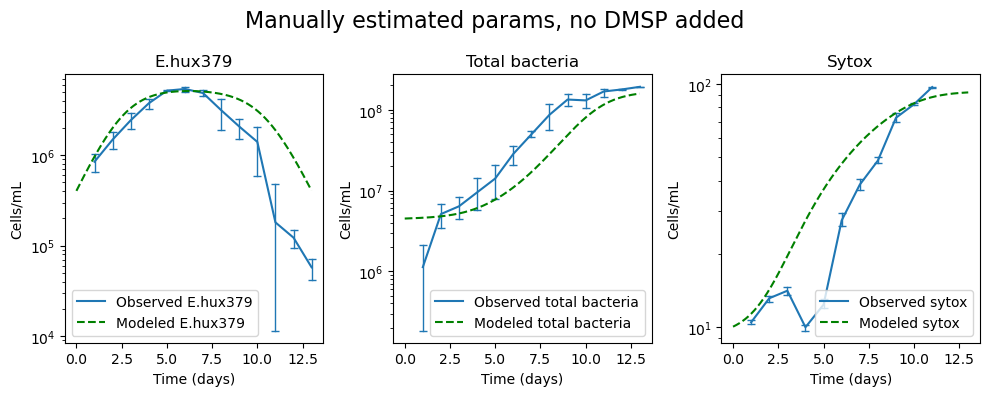

In [7]:
# model with phi function

DEFAULT_PARAMS = {
    'H0': 4.0e5, 'B0': 5e5, 'P0': 4e6, 'k': 5.5e6, 'D0': 10,
    'H_mu': 1, 'B_mu': 0.1, 'D_mu': 2e-6, 'beta': 14, 'x':1.25e-10
}

def simulate_growth(params=None, order=None, tmin=0, tmax=20, dt=0.01):
    """
    Compact simulator.
    - params: dict of parameter_name->value OR sequence of values (then provide `order`).
    - order: list of parameter names for the sequence case (e.g. ['H_mu','phi'])
    - returns: times, Hs, Bs, Ps, Ds, BPs (numpy arrays)
    """
    p = DEFAULT_PARAMS.copy()
    if params is not None:
        if isinstance(params, dict):
            p.update(params)
        else:
            if order is None:
                raise ValueError("If params is a sequence, provide `order` list of names.")
            if len(params) != len(order):
                raise ValueError("Length of params sequence and order must match.")
            for name, val in zip(order, params):
                p[name] = val

    times = np.arange(tmin, tmax, dt)
    H, B, P, D, x = p['H0'], p['B0'], p['P0'], p['D0'], p['x']
    Hs, Bs, Ps, Ds, BPs, phis = [], [], [], [], [], []

    for _ in times:
        phi=D*p['x']
        H += dt * (p['H_mu'] * H * (1 - (H / p['k'])) - phi * H * P)
        B += dt * (p['B_mu'] * B)
        P += dt * (p['beta'] * phi * H * P)
        D += dt * (p['D_mu'] * H)
        
        Hs.append(H); Bs.append(B); Ps.append(P); Ds.append(D); BPs.append(B + P); phis.append(phi)

    return times, np.array(Hs), np.array(Bs), np.array(Ps), np.array(Ds), np.array(BPs), np.array(phis)

times, Hs, Bs, Ps, Ds, BPs, phis = simulate_growth(tmax=13, dt=0.01)

f, ax = plt.subplots(1,3, figsize=(10,4))
plot_line(ax=ax[0], df=filter_df(df, name='ehux379', d7=True), style=None, hue=None, palette=None, label="Observed E.hux379")
plot_line(ax=ax[1], df=filter_df(df, name='bacteria', d7=True), style=None, hue=None, palette=None, label="Observed total bacteria")
plot_line(ax=ax[2], df=filter_df(df, name='sytox', d7=True), style=None, hue=None, palette=None, label="Observed sytox")
sns.lineplot(x=times, y=Hs, ax=ax[0], label='Modeled E.hux379', linestyle='--', c='green')
sns.lineplot(x=times, y=BPs, ax=ax[1], label='Modeled total bacteria', linestyle='--', c='green')
sns.lineplot(x=times, y=Ds, ax=ax[2], label='Modeled sytox', linestyle='--', c='green')
f.suptitle('Manually estimated params, no DMSP added', fontsize=16)
ax[0].set_title('E.hux379')
ax[1].set_title('Total bacteria')
ax[2].set_title('Sytox')
plt.tight_layout()

In [8]:
# Parameters to fit
param_names = ['x', 'beta']
bounds = [(1e-11, 1e-9),    # x bounds
          (1, 40)]        # beta bounds
# Example observed data (replace with real data)
t_obs = filter_df(df, name='ehux379', d7=True)['time']
H_obs = filter_df(df, name='ehux379', d7=True)['r']
BP_obs = filter_df(df, name='bacteria', d7=True)['r']
D_obs = filter_df(df, name='sytox', d7=True)['r']

def mse_norm(y_true, y_pred):
    scale = np.max(y_true) - np.min(y_true)
    if scale == 0: scale = np.mean(y_true)
    return np.mean((y_true - y_pred)**2) / (scale**2)

def cost_function(params):
    # simulate with current guess
    times, Hs, Bs, Ps, Ds, BPs, phis = simulate_growth(params, order=param_names,
                                                 tmin=0, tmax=20, dt=0.01)
    # interpolate model onto observed timepoints
    H_model = np.interp(t_obs, times, Hs)
    BP_model = np.interp(t_obs, times, BPs)
    D_model = np.interp(t_obs, times, Ds)
    error = (mse_norm(H_obs, H_model) +
             mse_norm(BP_obs, BP_model))
    return error

result = differential_evolution(cost_function, bounds)
print("Best parameters:", dict(zip(param_names, result.x)))
print("Error:", result.fun)


Best parameters: {'x': np.float64(1.716385152650876e-10), 'beta': np.float64(16.880320326346155)}
Error: 0.017337640953798212


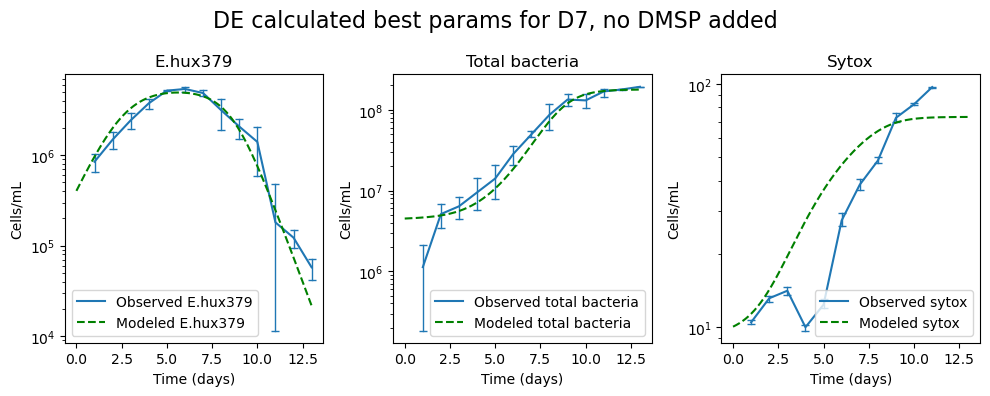

In [9]:
# plot DE estimated best fit
# enter estimated best params
times, Hs, Bs, Ps, Ds, BPs, phis = simulate_growth(tmax=13, dt=0.01, params={
    'x': 1.72756893068508e-10, 'beta': 16.768000724522206
})

f, ax = plt.subplots(1,3, figsize=(10,4))
plot_line(ax=ax[0], df=filter_df(df, name='ehux379', d7=True), style=None, hue=None, palette=None, label="Observed E.hux379")
plot_line(ax=ax[1], df=filter_df(df, name='bacteria', d7=True), style=None, hue=None, palette=None, label="Observed total bacteria")
plot_line(ax=ax[2], df=filter_df(df, name='sytox', d7=True), style=None, hue=None, palette=None, label="Observed sytox")
sns.lineplot(x=times, y=Hs, ax=ax[0], label='Modeled E.hux379', linestyle='--', c='green')
sns.lineplot(x=times, y=BPs, ax=ax[1], label='Modeled total bacteria', linestyle='--', c='green')
sns.lineplot(x=times, y=Ds, ax=ax[2], label='Modeled sytox', linestyle='--', c='green')
f.suptitle('DE calculated best params for D7, no DMSP added', fontsize=16)
ax[0].set_title('E.hux379')
ax[1].set_title('Total bacteria')
ax[2].set_title('Sytox')
plt.tight_layout()

Text(0.5, 0, 'modeled dead cells')

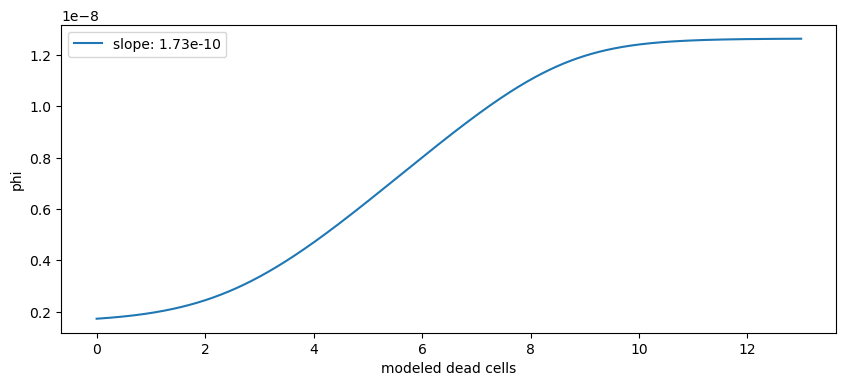

In [10]:
f, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(y=phis, x=times, label='slope: 1.73e-10')
ax.set_ylabel('phi')
ax.set_xlabel('modeled dead cells')

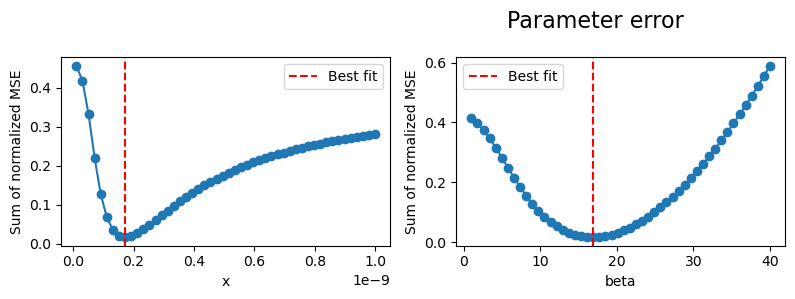

In [11]:
best_params = result.x

def scan_param(idx, n_points=50):
    """Scan one parameter index, keeping others fixed at best fit."""
    param_values = np.linspace(bounds[idx][0], bounds[idx][1], n_points)
    errors = []
    for val in param_values:
        test_params = best_params.copy()
        test_params[idx] = val
        errors.append(cost_function(test_params))
    return param_values, np.array(errors)

plt.figure(figsize=(12,3))
for i, name in enumerate(param_names):
    vals, errs = scan_param(i)
    plt.subplot(1,3,i+1)
    plt.plot(vals, errs, '-o')
    plt.axvline(best_params[i], color='r', linestyle='--', label="Best fit")
    plt.xlabel(name); plt.ylabel("Sum of normalized MSE")
    plt.legend()
plt.suptitle('Parameter error', fontsize=16)
plt.tight_layout()
plt.show()

# With DMSP added

In [12]:
# load and filter data
df=filter_df(df=load_data(), treatment='dmsp', treatment_conc=100, host='ehux379')

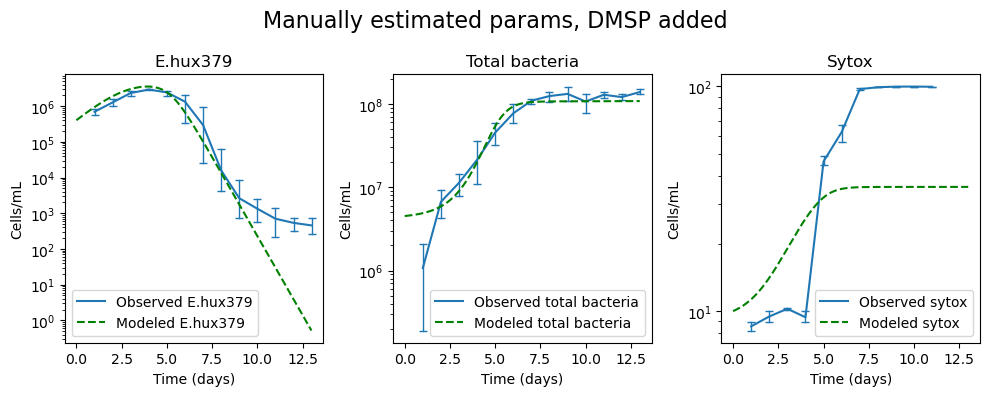

In [13]:
# model with phi function

DEFAULT_PARAMS = {
    'H0': 4.0e5, 'B0': 5e5, 'P0': 4e6, 'k': 5.5e6, 'D0': 10,
    'H_mu': 1, 'B_mu': 0.1, 'D_mu': 2e-6, 'beta': 14, 'x':8e-10
}

def simulate_growth(params=None, order=None, tmin=0, tmax=20, dt=0.01):
    """
    Compact simulator.
    - params: dict of parameter_name->value OR sequence of values (then provide `order`).
    - order: list of parameter names for the sequence case (e.g. ['H_mu','phi'])
    - returns: times, Hs, Bs, Ps, Ds, BPs (numpy arrays)
    """
    p = DEFAULT_PARAMS.copy()
    if params is not None:
        if isinstance(params, dict):
            p.update(params)
        else:
            if order is None:
                raise ValueError("If params is a sequence, provide `order` list of names.")
            if len(params) != len(order):
                raise ValueError("Length of params sequence and order must match.")
            for name, val in zip(order, params):
                p[name] = val

    times = np.arange(tmin, tmax, dt)
    H, B, P, D, x = p['H0'], p['B0'], p['P0'], p['D0'], p['x']
    Hs, Bs, Ps, Ds, BPs, phis = [], [], [], [], [], []

    for _ in times:
        phi=D*p['x']
        H += dt * (p['H_mu'] * H * (1 - (H / p['k'])) - phi * H * P)
        B += dt * (p['B_mu'] * B)
        P += dt * (p['beta'] * phi * H * P)
        D += dt * (p['D_mu'] * H)
        
        Hs.append(H); Bs.append(B); Ps.append(P); Ds.append(D); BPs.append(B + P); phis.append(phi)

    return times, np.array(Hs), np.array(Bs), np.array(Ps), np.array(Ds), np.array(BPs), np.array(phis)

times, Hs, Bs, Ps, Ds, BPs, phis = simulate_growth(tmax=13, dt=0.01)

f, ax = plt.subplots(1,3, figsize=(10,4))
plot_line(ax=ax[0], df=filter_df(df, name='ehux379', d7=True), style=None, hue=None, palette=None, label="Observed E.hux379")
plot_line(ax=ax[1], df=filter_df(df, name='bacteria', d7=True), style=None, hue=None, palette=None, label="Observed total bacteria")
plot_line(ax=ax[2], df=filter_df(df, name='sytox', d7=True), style=None, hue=None, palette=None, label="Observed sytox")
sns.lineplot(x=times, y=Hs, ax=ax[0], label='Modeled E.hux379', linestyle='--', c='green')
sns.lineplot(x=times, y=BPs, ax=ax[1], label='Modeled total bacteria', linestyle='--', c='green')
sns.lineplot(x=times, y=Ds, ax=ax[2], label='Modeled sytox', linestyle='--', c='green')
f.suptitle('Manually estimated params, DMSP added', fontsize=16)
ax[0].set_title('E.hux379')
ax[1].set_title('Total bacteria')
ax[2].set_title('Sytox')
plt.tight_layout()

In [14]:
# Parameters to fit
param_names = ['x', 'beta']
bounds = [(1e-11, 1e-9),    # x bounds
          (1, 40)]        # beta bounds
# Example observed data (replace with real data)
t_obs = filter_df(df, name='ehux379', d7=True)['time']
H_obs = filter_df(df, name='ehux379', d7=True)['r']
BP_obs = filter_df(df, name='bacteria', d7=True)['r']
D_obs = filter_df(df, name='sytox', d7=True)['r']

def mse_norm(y_true, y_pred):
    scale = np.max(y_true) - np.min(y_true)
    if scale == 0: scale = np.mean(y_true)
    return np.mean((y_true - y_pred)**2) / (scale**2)

def cost_function(params):
    # simulate with current guess
    times, Hs, Bs, Ps, Ds, BPs, phis = simulate_growth(params, order=param_names,
                                                 tmin=0, tmax=20, dt=0.01)
    # interpolate model onto observed timepoints
    H_model = np.interp(t_obs, times, Hs)
    BP_model = np.interp(t_obs, times, BPs)
    D_model = np.interp(t_obs, times, Ds)
    error = (mse_norm(H_obs, H_model) +
             mse_norm(BP_obs, BP_model))
    return error

result = differential_evolution(cost_function, bounds)
print("Best parameters:", dict(zip(param_names, result.x)))
print("Error:", result.fun)


Best parameters: {'x': np.float64(7.22854202313214e-10), 'beta': np.float64(14.849674118037772)}
Error: 0.0331610162249613


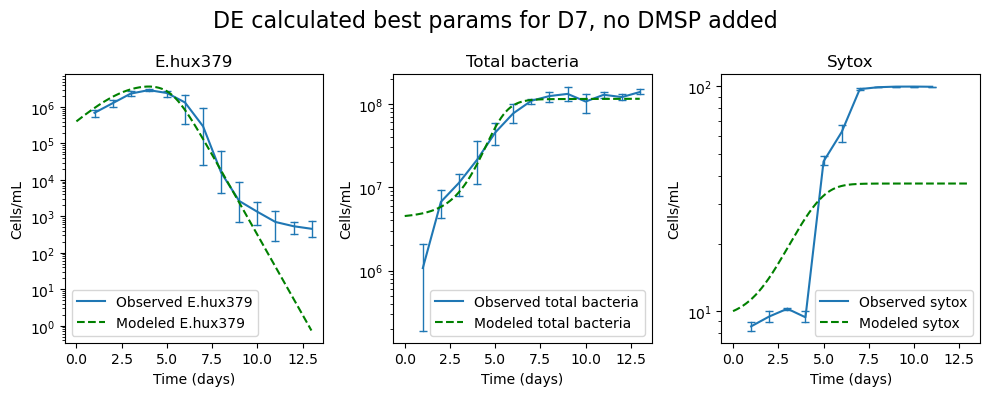

In [15]:
# plot DE estimated best fit
# enter estimated best params
times, Hs, Bs, Ps, Ds, BPs, phis = simulate_growth(tmax=13, dt=0.01, params={
    'x': 7.209917216592954e-10, 'beta': 14.699471632889821
})

f, ax = plt.subplots(1,3, figsize=(10,4))
plot_line(ax=ax[0], df=filter_df(df, name='ehux379', d7=True), style=None, hue=None, palette=None, label="Observed E.hux379")
plot_line(ax=ax[1], df=filter_df(df, name='bacteria', d7=True), style=None, hue=None, palette=None, label="Observed total bacteria")
plot_line(ax=ax[2], df=filter_df(df, name='sytox', d7=True), style=None, hue=None, palette=None, label="Observed sytox")
sns.lineplot(x=times, y=Hs, ax=ax[0], label='Modeled E.hux379', linestyle='--', c='green')
sns.lineplot(x=times, y=BPs, ax=ax[1], label='Modeled total bacteria', linestyle='--', c='green')
sns.lineplot(x=times, y=Ds, ax=ax[2], label='Modeled sytox', linestyle='--', c='green')
f.suptitle('DE calculated best params for D7, no DMSP added', fontsize=16)
ax[0].set_title('E.hux379')
ax[1].set_title('Total bacteria')
ax[2].set_title('Sytox')
plt.tight_layout()

# Other Code

AttributeError: Line2D.set() got an unexpected keyword argument 'filters'

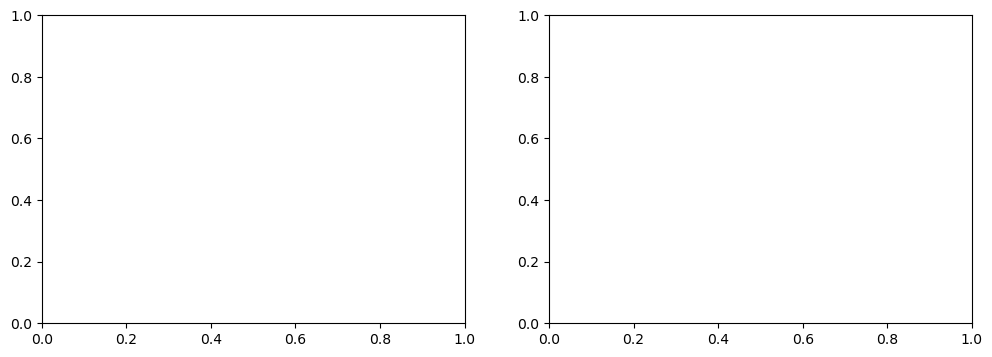

In [16]:
f, ax = plt.subplots(1,2, figsize=(12, 4))
plot_line(ax[0], df, 
          filters=dict(treatment='dmsp', treatment_conc=100, name='ehux379', host='ehux379'), 
          title=('E.Hux379 growth vs model (0 DMSP)'))
plot_line(ax[1], df, 
          filters=dict(treatment='dmsp', treatment_conc=100, name='bacteria', host='ehux379'), 
          title=('E.Hux379 growth vs model (0 DMSP)'))

# No D7 params
# {'phi': np.float64(-8.8736), 'beta': np.float64(40.2321), 
# 'H_mu': np.float64(0.853), 'B_mu': np.float64(0.2696), 
# 'H0': np.float64(5.5228), 'B0': np.float64(4.895), 
# 'k': np.float64(6.7201)}

times, Hs, Bs, Ps, Ds, BPs = simulate_growth(phi=10**-8.8736, beta=40.2321, 
                                        H_mu=0.853, B_mu=0.2696,
                                        H0=10**5.5228, B0=10**4.895, k=10**6.7201)
sns.lineplot(x=times, y=Hs, ax=ax[0], label='Modeled E.Hux379 - No D7', linestyle='--', c='red')
sns.lineplot(x=times, y=Bs, ax=ax[1], label='Modeled Bacteria - No D7', linestyle='--', c='red')

# D7 params
# {'phi': np.float64(-7.7027), 'beta': np.float64(20.7348), 
# 'H_mu': np.float64(0.5555), 'B_mu': np.float64(0.2731), 
# 'H0': np.float64(5.7448), 'B0': np.float64(4.9163), 
# 'k': np.float64(7.1888)}
times, Hs, Bs, Ps, Ds, BPs = simulate_growth(phi=10**-7.7027, beta=20.7348, 
                                        H_mu=0.5555, B_mu=0.2731,
                                        H0=10**5.7448, B0=10**4.9163, k=10**7.1888)
sns.lineplot(x=times, y=Hs, ax=ax[0], label='Modeled E.Hux379 - D7', linestyle='--', c='green')
sns.lineplot(x=times, y=Ps+Bs, ax=ax[1], label='Modeled Bacteria - D7', linestyle='--', c='green')

ax[0].legend(
              loc="upper center",      # place legend in the center
              bbox_to_anchor=(0.5, -0.2),  # push below axis label
              ncol=2,                  # make labels go side by side
              frameon=True            # optional: remove box
    )
ax[1].legend(
              loc="upper center",      # place legend in the center
              bbox_to_anchor=(0.5, -0.2),  # push below axis label
              ncol=2,                  # make labels go side by side
              frameon=True            # optional: remove box
    )
ax[0].set_xlim(right=13.5)
ax[1].set_xlim(right=13.5)
ax[0].set_ylim(top=1e7, bottom=1e3)
ax[1].set_ylim(top=1e9, bottom=1e4)
plt.tight_layout()
plt.show()


AttributeError: Line2D.set() got an unexpected keyword argument 'filters'

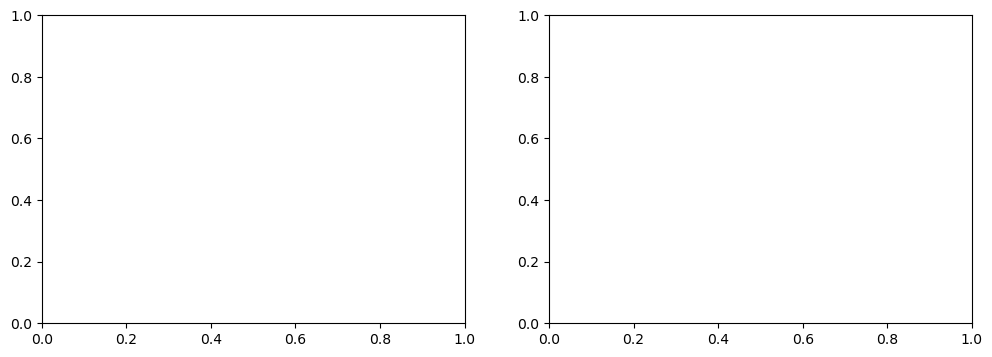

In [17]:
# Example: Algal & bacterial growth, filtered
f, ax = plt.subplots(ncols=2, figsize=(12, 4))
plot_line(ax[0], df, filters=dict(treatment='dmsp', name='ehux379', host='ehux379'),
          title="Algal growth (ehux379)")
plot_line(ax[1], df, filters=dict(treatment='dmsp', name='bacteria', host='ehux379'),
          title="Bacterial growth")
plt.tight_layout()
plt.show()

f, ax = plt.subplots(4,2, figsize=(10, 16))
plot_line(ax[0,0], df, 
          filters=dict(treatment='none', treatment_conc='none', name='ehux379', host='ehux379'), 
          title=('E.Hux379 growth with and without D7 (0 DMSP)'))

plot_line(ax[0,1], df, 
          filters=dict(treatment='none', treatment_conc='none', name='bacteria', host='ehux379'), 
          title=('Bacteria growth with and without D7 (0 DMSP)'))

plot_line(ax[1,0], df, 
          filters=dict(treatment='dmsp', treatment_conc=10, name='ehux379', host='ehux379'), 
          title=('E.Hux379 growth with and without D7 (10 DMSP)'))

plot_line(ax[1,1], df, 
          filters=dict(treatment='dmsp', treatment_conc=10, name='bacteria', host='ehux379'), 
          title=('Bacteria growth with and without D7 (10 DMSP)'))

plot_line(ax[2,0], df, 
          filters=dict(treatment='dmsp', treatment_conc=100, name='ehux379', host='ehux379'), 
          title=('E.Hux379 growth with and without D7 (100 DMSP)'))

plot_line(ax[2,1], df, 
          filters=dict(treatment='dmsp', treatment_conc=100, name='bacteria', host='ehux379'), 
          title=('Bacteria growth with and without D7 (100 DMSP)'))

plot_line(ax[3,0], df, 
          filters=dict(treatment='dmsp', treatment_conc=500, name='ehux379', host='ehux379'), 
          title=('E.Hux379 growth with and without D7 (500 DMSP)'))

plot_line(ax[3,1], df, 
          filters=dict(treatment='dmsp', treatment_conc=500, name='bacteria', host='ehux379'), 
          title=('Bacteria growth with and without D7 (500 DMSP)'))

plt.tight_layout()
plt.show()